### 1. Environment Settings

#### 1.1 Import Library

In [8]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel, AutoTokenizer, AutoModel
from transformers.optimization import get_cosine_schedule_with_warmup

#### 1.2 Setting Default Value

In [9]:
data_path = "/home/lamda_00/Depression_paper/data/"
model_path = "/home/lamda_00/Depression_paper/model/"
ckpt_path = "/home/lamda_00/Depression_paper/ckpt/"
config_path = "/home/lamda_00/Depression_paper/config/"
log_path = "/home/lamda_00/Depression_paper/log/"
config_file = "bert-base.json"

#### 1.3 Load Dataset 

In [10]:
label = dict()

label[0] = '우울'
label[1] = '무기력'
label[2] = '급격한 체중(식욕)변화'
label[3] = '수면장애'
label[4] = '정서불안'
label[5] = '피로'
label[6] = '과도한 죄책감 및 무가치함'
label[7] = '인지기능저하'
label[8] = '자살충동'
label[9] = '일상'
label

{0: '우울',
 1: '무기력',
 2: '급격한 체중(식욕)변화',
 3: '수면장애',
 4: '정서불안',
 5: '피로',
 6: '과도한 죄책감 및 무가치함',
 7: '인지기능저하',
 8: '자살충동',
 9: '일상'}

In [13]:
dsm_data = pd.read_csv(os.path.join(data_path, 'dsm_data.csv'))
dsm_data

/tmp/ipykernel_9317/2633627116.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dsm_data = pd.read_csv(os.path.join(data_path, 'dsm_data.csv'))


,id,text,label
0,al526,"so, am i depressed? i'm honestly unsure myself...",0
1,as8qg,"i originally put it in askreddit, but realized...",0
2,as8qg,how did you do it? am i even depressed at all?...,0
3,ay63c,have been depressed for approximately 20 years...,0
4,aycre,i don't know if i'm depressed or if i'm being ...,0
...,...,...,...
300070,126547,It is said that the incidence of respiratory d...,9
300071,126547,"It was a little uncomfortable at first, but no...",9
300072,126547,I think I'll wear a mask for the rest of my li...,9
300073,126547,I think I should accept it as a habit now.,9


In [12]:
# dsm_sample: label_10, dsm_sample2: label_9
dsm_sample = pd.read_csv(os.path.join(data_path, 'dsm_sample2.csv'))
dsm_sample.head(3)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lamda_00/Depression_paper/data/dsm_sample2.csv'

In [108]:
dsm_data.groupby('label').count()

,id,text
label,,
0,87891,87891
1,2078,2078
2,5129,5129
3,7228,7228
4,716,716
5,1741,1741
6,41758,41758
7,2452,2452
8,52860,52860


In [18]:
dsm_data[dsm_data.label==8]

,id,text,label
150201,amruc,"besides, i worked myself out of the suicidal p...",8
150202,aud8r,"i hate that on my ""good"" days i actually becom...",8
150203,b72of,"therapy, medication, self-medication, suicidal...",8
150205,bak16,the depressed mode sometimes becomes panicky-d...,8
150206,bivnx,i have also been struggling with some suicidal...,8
...,...,...,...
206146,54jkqa,"i don't want to say i want to die, because i d...",8
206147,t3_28v4mc,"i don't really want to die, but sometimes i th...",8
206148,t3_4op4fb,"i don't really want to die, there are times wh...",8
206149,t3_50ycys,i too just want to die or just disappear,8


In [109]:
dsm_sample = dsm_data.copy()
dsm = []

dsm.extend(dsm_sample[dsm_sample.label==0].sample(40000).index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==1].index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==2].index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==3].index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==4].index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==5].index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==6].sample(20000).index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==7].index.tolist())
dsm.extend(dsm_sample[dsm_sample.label==8].sample(20000).index.tolist())

len(dsm)

99344

In [110]:
dsm_sample = dsm_sample.loc[dsm]
dsm_sample.to_csv(os.path.join(data_path, 'dsm_sample2.csv'), index=False)

In [111]:
X_train, X_test = train_test_split(dsm_sample, test_size=0.2, random_state=42, stratify=dsm_sample['label'])
X_train, X_dev = train_test_split(X_train, test_size=0.2, random_state=42, stratify=X_train['label'])
len(X_train), len(X_dev), len(X_test)

(63580, 15895, 19869)

In [112]:
X_train.groupby('label').count()

,id,text
label,,
0,25600,25600
1,1330,1330
2,3282,3282
3,4626,4626
4,458,458
5,1114,1114
6,12800,12800
7,1570,1570
8,12800,12800


In [113]:
X_train.to_csv(os.path.join(data_path, 'dsm_samp2_train.csv'), index=False)
X_dev.to_csv(os.path.join(data_path, 'dsm_samp2_val.csv'), index=False)
X_test.to_csv(os.path.join(data_path, 'dsm_samp2_test.csv'), index=False)

#### 1.4 Load Pretrained model & tokenizer 

In [115]:
X_train = pd.read_csv(os.path.join(data_path, 'dsm_samp_train.csv'))
X_dev = pd.read_csv(os.path.join(data_path, 'dsm_samp_val.csv'))
X_test = pd.read_csv(os.path.join(data_path, 'dsm_samp_test.csv'))

In [116]:
len(X_train), len(X_dev), len(X_test)

(63580, 15895, 19869)

In [117]:
X_train.label.unique()

array([6, 8, 0, 9, 3, 1, 2, 4, 5, 7])

In [118]:
for i, name in label.items():
    print(name)

우울
무기력
급격한 체중(식욕)변화
수면장애
정서불안
피로
과도한 죄책감 및 무가치함
인지기능저하
자살충동
일상


In [119]:
model_path

'/home/lamda_00/Depression_paper/model/'

In [192]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-base'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-base', 'bert_config.json'), num_labels=10)
model = BertForSequenceClassification.from_pretrained(os.path.join(model_path, 'bert-base'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCl

In [193]:
config.attention_probs_dropout_prob, config.hidden_size

(0.1, 768)

#### 1.5 setting training args & config 

In [194]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [195]:
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [196]:
training_config

AttrDict({'default_path': '../', 'data_path': 'data', 'log_path': 'log', 'model_path': 'model', 'config_path': 'config', 'seed': 42, 'train_batch_size': 32, 'device': device(type='cuda'), 'eval_batch_size': 32, 'num_epochs': 500, 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.0, 'adam_epsilon': 1e-08, 'warmup_proportion': 0, 'learning_rate': 5e-05, 'do_lower_case': False, 'no_cuda': False, 'max_steps': -1, 'logging_steps': 100})

In [197]:
training_config.learning_rate

5e-05

In [198]:
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 2. Define Class

In [199]:
training_config.pad = 'max_length'
training_config.num_epochs  = 500

In [200]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    # def clear_text(self)  => 전처리 코드를 여기에 넣을 경우 상당히 느려짐
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [201]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sentence_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        pass
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [202]:
training_config.num_epochs
training_config

AttrDict({'default_path': '../', 'data_path': 'data', 'log_path': 'log', 'model_path': 'model', 'config_path': 'config', 'seed': 42, 'train_batch_size': 32, 'device': device(type='cuda'), 'eval_batch_size': 32, 'num_epochs': 500, 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.0, 'adam_epsilon': 1e-08, 'warmup_proportion': 0, 'learning_rate': 5e-05, 'do_lower_case': False, 'no_cuda': False, 'max_steps': -1, 'logging_steps': 100, 'pad': 'max_length'})

In [203]:
torch.tensor([1, 2, 3])

tensor([1, 2, 3])

In [204]:
class BertTrainer():
    def __init__(self, config, training_config, model, train_dataloader, eval_dataloader):
        self.config = config
        self.training_config = training_config
        self.model = model
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        
    def set_seed(self):
        random.seed(self.training_config.seed)
        np.random.seed(self.training_config.seed)
        torch.manual_seed(self.training_config.seed)
        if not self.training_config.no_cuda and torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.training_config.seed)
    
    def train(self):
        train_acc_list = []; eval_acc_list = [] 
        train_loss_list = []; eval_loss_list = []
        # eval_acc_step = []; eval_loss_step = []
        # train_acc_step = []; train_loss_step = []
        nb_eval_steps = 0
        best_loss = 9999; best_epoch = 0
        t_total = len(self.train_dataloader) // self.training_config.gradient_accumulation_steps * self.training_config.num_epochs

        optimizer = AdamW(self.model.parameters(), lr=self.training_config.learning_rate, eps=self.training_config.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * self.training_config.warmup_proportion), \
                                                    num_training_steps=t_total)

        self.model.zero_grad()
        for epoch in range(int(self.training_config.num_epochs)):
            train_acc = 0.0; eval_acc = 0.0
            train_loss = 0.0; eval_loss = 0.0 

            for step, batch in enumerate(self.train_dataloader):
                self.model.train()
                batch = tuple(t.to(self.training_config.device) for t in batch)
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = self.model(**inputs)
                criterion = nn.CrossEntropyLoss()
                # loss = outputs[0]
                # y_pred = torch.max(outputs[1], 1)[1]
                y_pred = outputs[1]
                y_true = batch[3]
                # y_true = torch.tensor([float(t) for t in y_true]).to(self.training_config.device)
                loss = criterion(y_pred, y_true)
                # print(outputs[0], outputs[1], batch[3])
                loss.backward()
                train_loss += loss.item()
                train_acc += self.calc_accuracy(outputs[1], batch[3])

                optimizer.step()
                scheduler.step()
                self.model.zero_grad()
                '''
                if step % training_config.logging_steps == 0:
                    # print(f'step: {step}, {train_acc / (step + 1)}')
                    # print(f'step: {step}, {train_loss / (step + 1)}')
                    train_acc_step.append([step, train_acc / (step + 1)])
                    train_loss_step.append([step, train_loss / (step + 1)])'''

            train_acc = train_acc / (step + 1)
            print(f'epoch: {epoch}, train_loss: {train_loss}')
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)

            for step2, batch2 in enumerate(self.eval_dataloader):
                self.model.eval()
                batch2 = tuple(t.to(self.training_config.device) for t in batch2)

                with torch.no_grad():
                    inputs = {
                        "input_ids": batch2[0],
                        "attention_mask": batch2[1],
                        "token_type_ids": batch2[2],
                        "labels": batch2[3]
                    }
                    outputs = self.model(**inputs)
                    tmp_eval_loss, logits = outputs[:2]
                    loss2 = criterion(logits, batch2[3])
                    eval_loss += loss2.item()              
                    # eval_loss += tmp_eval_loss.mean().item()
                    eval_acc += self.calc_accuracy(outputs[1], batch2[3]) 
                    '''
                    if step2 % training_config.logging_steps == 0:
                        eval_acc_step.append([step2, eval_acc / (step + 1)])
                        eval_loss_step.append([step2, eval_loss / (step + 1)])'''
            '''            
            try:
                last_loss = eval_loss_list[-1]
            except:
                last_loss = 9999
            '''
            eval_loss = eval_loss / (step2 + 1)
            eval_acc = eval_acc / (step2 + 1)
            eval_acc_list.append(eval_acc)
            eval_loss_list.append(eval_loss)
            print(f'epoch: {epoch}, eval_loss: {eval_loss}')
            
            if eval_loss < best_loss:
                best_loss = eval_loss
                es = 0
                print(f'save best loss state model & log(epoch {epoch + 1})')
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_dsm_{epoch}.pt'))
                best_epoch = epoch
            else:
                es += 1
                print("Counter {} of 7".format(es))

            if es > 6:
                print("Early stopping with best_loss: ", best_loss, "and val_loss for this epoch: ", eval_loss, "...")
                break
                
            '''
            if eval_loss > last_loss:
                trigger_times += 1
                print('Trigger Times:', trigger_times)
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_{epoch}.pt'))
                
                if trigger_times > 4:
                    print("Early stopping !")
                    self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_best.pt'))
                    break
            else:
                print('trigger times: 0')
                trigger_times = 0'''
            

        self.save_log(train_acc_list, train_loss_list, eval_acc_list, eval_loss_list, epoch)
        return train_acc_list, train_loss_list, eval_acc_list, eval_loss_list

    def calc_accuracy(self, X,Y):
        max_vals, max_indices = torch.max(X, 1)
        train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
        return train_acc
    
    def compute_metrics(self, labels, preds):
        assert len(preds) == len(labels)
        acc = (labels == preds).mean()
        return {"acc": acc}
    
    def save_step_log(self, train_acc_step, train_loss_step, eval_acc_step, eval_loss_step, epoch):
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_step_{epoch}_acc.pickle'), 'wb') as f:
            pickle.dump(train_acc_step, f, pickle.HIGHEST_PROTOCOL)
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_step_{epoch}_loss.pickle'), 'wb') as f:
            pickle.dump(train_loss_step, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_step_{epoch}_acc.pickle'), 'wb') as f:
            pickle.dump(eval_acc_step, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_step_{epoch}_loss.pickle'), 'wb') as f:
            pickle.dump(eval_loss_step, f, pickle.HIGHEST_PROTOCOL)  
            
    def save_log(self, train_acc, train_loss, eval_acc, eval_loss, epoch):
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_{epoch}_acc.pickle'), 'wb') as f:
            pickle.dump(train_acc, f, pickle.HIGHEST_PROTOCOL)
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_{epoch}_loss.pickle'), 'wb') as f:
            pickle.dump(train_loss, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_{epoch}_acc.pickle'), 'wb') as f:
            pickle.dump(eval_acc, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_{epoch}_loss.pickle'), 'wb') as f:
            pickle.dump(eval_loss, f, pickle.HIGHEST_PROTOCOL)  
    
    def save_model(self, model_name):
        torch.save(self.model.state_dict(), model_name)

### 3. Model Train

In [205]:
X_train.label.unique()

array([6, 8, 0, 9, 3, 1, 2, 4, 5, 7])

In [206]:
train_file = BertDataset(X_train)
val_file = BertDataset(X_dev)

In [207]:
len(train_file), len(val_file)

(63580, 15895)

In [208]:
config.max_position_embeddings = 32
config.max_position_embeddings

32

In [209]:
bert_processor = BertProcessor(config, training_config, tokenizer)

In [210]:
train_dataset = bert_processor.convert_data(train_file)
val_dataset = bert_processor.convert_data(val_file)

In [211]:
train_sampler = bert_processor.shuffle_data(train_dataset, 'train')
val_sampler = bert_processor.shuffle_data(val_dataset, 'eval')

In [212]:
train_dataloader = bert_processor.load_data(train_dataset, train_sampler)
val_dataloader = bert_processor.load_data(val_dataset, val_sampler)

In [213]:
len(train_dataloader), len(val_dataloader)

(1987, 497)

In [214]:
bert_trainer = BertTrainer(config, training_config, model, train_dataloader, val_dataloader)

In [215]:
train_acc, train_loss, eval_acc, eval_loss = bert_trainer.train()

epoch: 0, train_loss: 248.3740598752629
epoch: 0, eval_loss: 0.05096935437206587
save best loss state model & log(epoch 1)
epoch: 1, train_loss: 106.87129963678308
epoch: 1, eval_loss: 0.0514270755217806
Counter 1 of 7
epoch: 2, train_loss: 76.87130812357645
epoch: 2, eval_loss: 0.05343853877491919
Counter 2 of 7
epoch: 3, train_loss: 67.3428502138413
epoch: 3, eval_loss: 0.04819384058011027
save best loss state model & log(epoch 4)
epoch: 4, train_loss: 52.54140174033819
epoch: 4, eval_loss: 0.04979538091467047
Counter 1 of 7
epoch: 5, train_loss: 44.59284018780454
epoch: 5, eval_loss: 0.05232976792287456
Counter 2 of 7
epoch: 6, train_loss: 41.28900588596298
epoch: 6, eval_loss: 0.057177754054623664
Counter 3 of 7
epoch: 7, train_loss: 33.45048954570666
epoch: 7, eval_loss: 0.060633899366506046
Counter 4 of 7
epoch: 8, train_loss: 37.39650171723042
epoch: 8, eval_loss: 0.12861444413337775
Counter 5 of 7
epoch: 9, train_loss: 32.43412399854424
epoch: 9, eval_loss: 0.0603993325078168
C

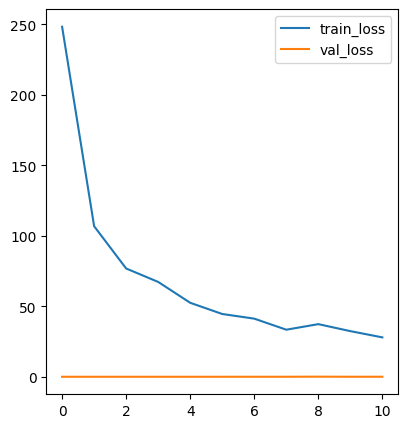

In [217]:
num_epochs = list(range(len(train_loss)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
plt.plot(list(range(len(train_loss))), eval_loss, label='val_loss')

plt.legend()
plt.show()

### 3. Model Test 

In [144]:
label = dict()

label[0] = '우울'
label[1] = '무기력'
label[2] = '급격한 체중(식욕)변화'
label[3] = '수면장애'
label[4] = '정서불안'
label[5] = '피로'
label[6] = '과도한 죄책감 및 무가치함'
label[7] = '인지기능저하'
label[8] = '자살충동'
label[9] = '일상'
label

{0: '우울',
 1: '무기력',
 2: '급격한 체중(식욕)변화',
 3: '수면장애',
 4: '정서불안',
 5: '피로',
 6: '과도한 죄책감 및 무가치함',
 7: '인지기능저하',
 8: '자살충동',
 9: '일상'}

In [145]:
X_test = pd.read_csv(os.path.join(data_path, 'dsm_samp_test.csv'))
X_test

,id,text,label
0,132946,"Of course I do, but... That's what I've been t...",9
1,t3_uzhrj,hurting yourself just leads to so many more pr...,8
2,t3_1f6rlk,as if it never mattered anyways i'll go to sle...,3
3,77173,You said you'd know the heat from one Kiki.,9
4,t3_1dzb0x,"just because the ""cancer"" tells me i am worthl...",6
...,...,...,...
19864,t3_2s455q,"if you view it as a - z, it can be very easy f...",1
19865,43hkav,why the fuck should i be talking about suicide...,8
19866,t3_zhku3,it gave me terrible insomnias but it did work ...,3
19867,2ffx1w,i will be very depressed for days or weeks at ...,0


In [146]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-small'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-small', 'bert_config.json'), num_labels=10)
model = BertForSequenceClassification.from_pretrained(os.path.join(model_path, 'bert-small'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceC

In [147]:
config.max_position_embeddings = 32

In [148]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [149]:
training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [150]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    # def clear_text(self)  => 전처리 코드를 여기에 넣을 경우 상당히 느려짐
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [151]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification

        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sent_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        context2 = None 
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(sent_list, context2)], max_length=self.max_len, padding=self.pad, truncation=self.truncation
        )
        
        features = []
        inputs = {k: batch_encoding[k][0] for k in batch_encoding}
        inputs['label'] = 0 
        features.append(inputs)

        input_id = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        input_am = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        input_tts = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        input_lb = torch.tensor([f['label'] for f in features], dtype=torch.long)
        dataset = TensorDataset(input_id, input_am, input_tts, input_lb)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [152]:
class BertTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()
            batch = tuple(t.to(self.training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = self.model(**inputs)
                test_loss, logits = outputs[:2] 
                pred = logits.detach().cpu().numpy()
                if test_type == 0:
                    preds.extend(np.argmax(pred, axis=1))
                elif test_type == 1:
                    preds.append(np.argmax(pred))  
                            
            label = inputs["labels"].detach().cpu().numpy()
            labels.extend(label)
  
        return preds, labels 
    
    def get_f1_score(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader)
        return round(f1_score(y_true, y_pred, average='micro'), 3) 
     
    def get_cl_report(self, test_dataloader):
        y_pred, y_true = self.get_label(test_dataloader)
        cr = classification_report(y_true, y_pred).split('\n')
        clr_df = []

        for idx, line in enumerate(cr):
            clr_df.append([])
            if line == '':
                continue

            word_list = line.strip().split(' ')

            for word in word_list:
                if word != '':
                    clr_df[idx].append(word)

        clr_df[-2][0] = ' '.join([clr_df[-2][0], clr_df[-2][1]])
        clr_df[-3][0] = ' '.join([clr_df[-3][0], clr_df[-3][1]])
        clr_df[-4].insert(1, ' ')
        clr_df[-4].insert(2, ' ')
        clr_df[0].insert(0, 'index')

        clr_df[-2].pop(1)
        clr_df[-3].pop(1)
        clr_df.pop(1)
        clr_df.pop(-1)
        clr_df.pop(-4)
        clr_df = pd.DataFrame(clr_df[1:], columns=clr_df[0])
        clr_df.index = clr_df['index']

        del clr_df['index']
        return clr_df

In [153]:
test_processor = BertProcessor(config, training_config, tokenizer)

In [154]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [155]:
model_path

'/home/lamda_00/Depression_paper/model/'

In [156]:
# model_name = os.path.join(model_path, 'label_9', 'bert_medium', 'bert_class.pt')
model_name = os.path.join(model_path, 'bert_dsm_2.pt')

In [157]:
model.load_state_dict(torch.load(model_name))
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [158]:
bert_tester = BertTester(training_config, model)

In [159]:
X_test.text[0]

"Of course I do, but... That's what I've been thinking lately"

In [160]:
with open(os.path.join(data_path, 'conv.pickle'), 'rb') as f:
    conv = pickle.load(f)

In [161]:
conv

,turn_cnt,speaker_idx,text
0,1,User,안녕
1,2,Chatbot,안녕하세요 ~ 반가워요
2,3,User,이름이 뭐야 ?
3,4,Chatbot,"저는 심리상담 챗봇, ~ 에요"
4,5,User,아하 ㅎㅎ
5,6,Chatbot,좋은 아침이에요
6,7,User,"그러게, 그런데 나는 기분이 우울해"
7,8,Chatbot,무슨 일 있어요 ?
8,9,User,그냥 요즘 너무 무기력한거 같아
9,10,Chatbot,무기력할 때는 몸을 움직여야 해요


In [162]:
conv.text.loc[6] = '오늘 너무 우울하다'
conv.text.loc[12] = '일이 너무 많아서 잠도 너무 못 자 '
conv

/tmp/ipykernel_9317/3337350865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv.text.loc[6] = '오늘 너무 우울하다'
/tmp/ipykernel_9317/3337350865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv.text.loc[12] = '일이 너무 많아서 잠도 너무 못 자 '


,turn_cnt,speaker_idx,text
0,1,User,안녕
1,2,Chatbot,안녕하세요 ~ 반가워요
2,3,User,이름이 뭐야 ?
3,4,Chatbot,"저는 심리상담 챗봇, ~ 에요"
4,5,User,아하 ㅎㅎ
5,6,Chatbot,좋은 아침이에요
6,7,User,오늘 너무 우울하다
7,8,Chatbot,무슨 일 있어요 ?
8,9,User,그냥 요즘 너무 무기력한거 같아
9,10,Chatbot,무기력할 때는 몸을 움직여야 해요


In [85]:
translated = ["hey", "Hello, nice to meet you", "what is your name ?", "I am a psychological counseling chatbot", "Ah-huh", \
              "good morning", "I'm so depressed today", "What's wrong?", "I just feel so lethargic these days", \
              "When you're lethargic, you have to move your body", "I think he's psychologically exhausted", \
              "I think you're really tired Is your work very hard?", "I can't sleep because I have too much work to do", \
              "I think it's good to take a break for a while", "I should I'll go for a walk from time to time", \
              "Taking a walk is good", "Thanks for listening", "Yes! See you next time"]

len(translated)

18

In [86]:
conv['translated'] = translated
conv

,turn_cnt,speaker_idx,text,translated
0,1,User,안녕,hey
1,2,Chatbot,안녕하세요 ~ 반가워요,"Hello, nice to meet you"
2,3,User,이름이 뭐야 ?,what is your name ?
3,4,Chatbot,"저는 심리상담 챗봇, ~ 에요",I am a psychological counseling chatbot
4,5,User,아하 ㅎㅎ,Ah-huh
5,6,Chatbot,좋은 아침이에요,good morning
6,7,User,오늘 너무 우울하다,I'm so depressed today
7,8,Chatbot,무슨 일 있어요 ?,What's wrong?
8,9,User,그냥 요즘 너무 무기력한거 같아,I just feel so lethargic these days
9,10,Chatbot,무기력할 때는 몸을 움직여야 해요,"When you're lethargic, you have to move your body"


In [87]:
with open(os.path.join(data_path, 'conv_translated.pickle'), 'wb') as f:
    pickle.dump(conv, f, pickle.HIGHEST_PROTOCOL)  

In [88]:
conv['translated'] = translated
conv = conv[['speaker_idx', 'translated']]
conv.columns = ['speaker', 'text']
conv.head()

,speaker,text
0,User,hey
1,Chatbot,"Hello, nice to meet you"
2,User,what is your name ?
3,Chatbot,I am a psychological counseling chatbot
4,User,Ah-huh


In [89]:
conv_list = conv.text.values.tolist()
conv_list

['hey',
 'Hello, nice to meet you',
 'what is your name ?',
 'I am a psychological counseling chatbot',
 'Ah-huh',
 'good morning',
 "I'm so depressed today",
 "What's wrong?",
 'I just feel so lethargic these days',
 "When you're lethargic, you have to move your body",
 "I think he's psychologically exhausted",
 "I think you're really tired Is your work very hard?",
 "I can't sleep because I have too much work to do",
 "I think it's good to take a break for a while",
 "I should I'll go for a walk from time to time",
 'Taking a walk is good',
 'Thanks for listening',
 'Yes! See you next time']

In [90]:
conv_list = conv.text.values.tolist()

conv_result = [] 
for text in conv_list: 
    conv_dataset = test_processor.convert_sentence(text)
    conv_sampler = test_processor.shuffle_data(conv_dataset, 'test')
    conv_dataloader = test_processor.load_data(conv_dataset, conv_sampler)
    y_pred, y_true = bert_tester.get_label(conv_dataloader)
    conv_result.append(y_pred[0])

In [91]:
conv['predict'] = conv_result
conv['predict'] = conv.predict.apply(lambda x: label[x])
conv

/tmp/ipykernel_14854/1442458656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv['predict'] = conv_result
/tmp/ipykernel_14854/1442458656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv['predict'] = conv.predict.apply(lambda x: label[x])


,speaker,text,predict
0,User,hey,우울
1,Chatbot,"Hello, nice to meet you",우울
2,User,what is your name ?,우울
3,Chatbot,I am a psychological counseling chatbot,과도한 죄책감 및 무가치함
4,User,Ah-huh,우울
5,Chatbot,good morning,수면장애
6,User,I'm so depressed today,우울
7,Chatbot,What's wrong?,우울
8,User,I just feel so lethargic these days,무기력
9,Chatbot,"When you're lethargic, you have to move your body",무기력


In [451]:
test_sent = "I can't sleep because I have too much work to do" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [159]:
len(test_dataloader)

498

In [114]:
X_test.groupby('label').count()

,id,text
label,,
0,4000,4000
1,418,418
2,1051,1051
3,1458,1458
4,143,143
5,351,351
6,2000,2000
7,496,496
8,2000,2000


In [163]:
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)

In [164]:
y_true[:3]

[9, 8, 3]

In [79]:
y_pred[:3]

[9, 8, 3]

In [81]:
y_pred, y_true = bert_tester.get_label(test_loader, 1)

NameError: name 'test_loader' is not defined

In [453]:
y_pred

[3]

In [163]:
y_true[:3]

[8, 1, 1]

In [403]:
y_pred[:3]

[8, 1, 1]

In [165]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, f1_score, classification_report

confusion_mt = pd.DataFrame(confusion_matrix(y_true, y_pred))
confusion_mt

,0,1,2,3,4,5,6,7,8,9
0,3945,0,3,7,3,0,19,2,15,6
1,3,407,0,1,0,0,3,0,2,0
2,1,1,1014,2,3,0,0,0,1,4
3,2,0,1,1440,0,0,1,1,1,0
4,0,0,0,2,141,0,0,0,0,0
5,2,0,1,3,3,338,1,0,0,0
6,13,0,3,5,0,0,3963,0,15,1
7,1,0,0,3,0,1,0,485,0,0
8,15,0,3,4,2,0,7,0,3959,10
9,14,1,10,13,2,0,1,5,24,3930
